# Stability test

## Interferometer chamber

### Under vacuum


Results on the measurements on 07/10/2019:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import pandas as pd
from tqdm import tqdm
import scipy.constants as cns
from scipy import stats

In [2]:
path = 'O:\\19_LaserData\\14_LTA1\\Automatic_recordings\\data\\frames'
fname = os.listdir(path)

In [3]:
fname = ['phases_20191007_171431.h5', 'phases_20191008_134955.h5', 'phases_20191008_141419.h5']


In [4]:
fname

['phases_20191007_171431.h5',
 'phases_20191008_134955.h5',
 'phases_20191008_141419.h5']

In [5]:
def read_h5file(name):
    with h5py.File(name, 'r') as f:
        ph = np.array(f['phase'])
        ti = np.array(f['time'])
        #raw = np.array(f['signal'])
    return (ti, ph)

def normalize_time(t):
    t = t - t.min()
    tmp = np.linspace(0, np.round(t.max()), len(t))
    return(tmp)


In [6]:
exp = []
for i,fn in tqdm(enumerate(fname)):
    fullname = os.path.join(path, fn)
    ti, ph = read_h5file(fullname)
    df = pd.DataFrame({'time':ti, 'phase':ph}, index=normalize_time(ti))
    exp.append(df)


3it [00:01,  2.32it/s]


In [7]:
exp[1].shape

(166755, 2)

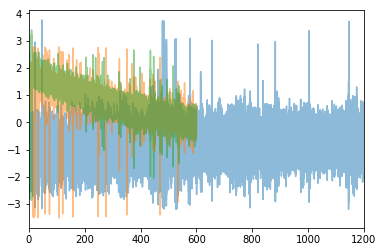

In [8]:
for i in exp:
    i['phase'].plot(alpha=0.5)

In [9]:
exp_mod=[]
for m in exp:
    tmp = m.copy()
    tmp=tmp.drop(columns=['time'])
    tmp.phase = tmp.phase - tmp.phase.mean()
    par = np.polyfit(tmp.index.values, tmp.phase, 2)
    ff = np.poly1d(par)
    tmp.phase = tmp.phase - ff(tmp.index)
    tmp['20p_std'] = tmp.phase.rolling(20, center=True).std()
    tmp['std'] = tmp.phase.std()
    exp_mod.append(tmp)

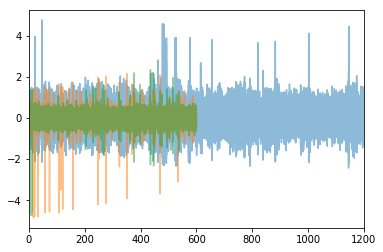

In [15]:
for i in exp_mod:
    i['phase'].plot(alpha=0.5)

Lets print out the standard deviation of the different measurements.

In [16]:
std=[]
for i in exp_mod:
    print(i.loc[0,'std'])
    std.append(i.loc[0,'std'])

0.48089852750784295
0.26684026967414937
0.20841533723380548


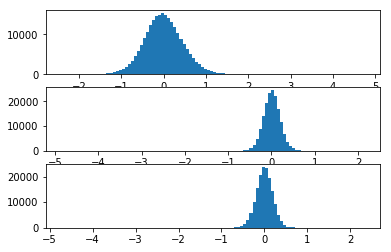

In [17]:
fig, _ = plt.subplots(nrows=3, ncols=1)
for j, i in enumerate(exp_mod):
    plt.subplot(3, 1, j+1)
    plt.hist(i[['phase']].values,bins=100)

It is easy to see that any data that is basically outside the -2..2 radian range is an artificial noise that is caused by a door or somebody dancing in the lab. To get a better estimate on the standard deviation we will not focus on the tail events. 

In [18]:
exp_filtered=[]
for m in exp_mod:
    tmp = m.copy()
    density = stats.gaussian_kde(m.phase)
    xx = np.linspace(m.phase.min(), m.phase.max(),300)
    dxx = xx[1] - xx[0]
    pdf = density.evaluate(xx)
    xx_mean = np.sum(xx * pdf) * dxx
    std = np.sqrt(np.sum(((xx-xx_mean)**2)*pdf)*dxx)
    tmp.phase = tmp.phase - xx_mean
    tmp = tmp[(tmp['phase'] > -2*std)]
    tmp = tmp[(tmp['phase'] < 2*std)]
    tmp['20p_std'] = tmp.phase.rolling(20, center=True).std()
    tmp['std'] = tmp.phase.std()
    exp_filtered.append(tmp)

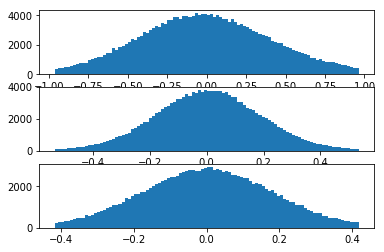

In [20]:
fig, _ = plt.subplots(nrows=3, ncols=1)
for j, i in enumerate(exp_filtered):
    plt.subplot(3, 1, j+1)
    plt.hist(i[['phase']].values,bins=100)

In [22]:
std=[]
for i in exp_filtered:
    print(i.loc[0,'std'])
    std.append(i.loc[0,'std'])
std=np.array(std)

0.4008042537582174
0.1864904233050025
0.17100118507636078


The average distance from the mean is $\pm$ {{std}} radians. Therefore it corresponds to a phase shift of $\Delta\phi$= {{2*std}} rad. Assuming a diode laser wavelength $\lambda$=530 nm, the phase shift corresponds to:

In [23]:
lbd = 530e-9
dphi=2*std
dx = dphi*lbd / (2*np.pi)
print(dx*1e9, 'nm')

[67.61737689 31.46172507 28.84862491] nm


This distance is done twice by the light on the interferometer so the temporal stability of the given interferometer is:

In [24]:
dt = 2*dx/cns.c
print(dt*1e18, 'as')

[451.09458284 209.89003713 192.45730933] as


### Spectral analysis

In [16]:
exp_fft=[]
for m in exp_mod:
    N = len(m.phase)
    t = m.index.values
    T = t.max() - t.min()
    dw = 2*np.pi / T
    dNu = 1 / (t[1]-t[0])
    print(dNu)
    freq = np.fft.fftshift(np.fft.fftfreq(N) * N * dw) / 2 / np.pi
    yft = np.fft.fftshift(np.fft.fft(m.phase))
    yft_hamming = np.fft.fftshift(np.fft.fft(m.phase * np.hamming(N)))
    tmp = pd.DataFrame({'fft':np.abs(yft), 'fft_hmg':yft_hamming, 'spectrum':np.abs(yft_hamming)}, index=freq)
    tmp['sp_smooth'] = tmp[['spectrum']].rolling(20, win_type='hamming', center=True).mean()
    exp_fft.append(tmp)

191.74166666666667
277.92333333333335
261.92833333333334


In [17]:
exp_fft[0].head()

,fft,fft_hmg,spectrum,sp_smooth
-95.870833,304.252116,(-93.17343401637977-220.0107402796274j),238.926798,NaN
-95.870000,209.843985,(96.5391741561877+102.44146104842457j),140.762442,NaN
-95.869167,186.813785,(27.497205620336665-65.357444591813j),70.906219,NaN
-95.868333,282.349877,(11.58509544364469+117.2810526355255j),117.851855,NaN
-95.867500,83.501539,(-12.647844620155357+44.58183463652954j),46.341212,NaN


(-10, 50)

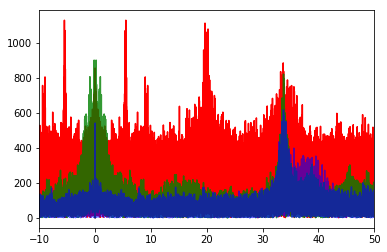

In [18]:
colors=['r', 'g', 'b', 'c']
alpha = 1
for j, i in enumerate(exp_fft):
    i['fft'].plot(color=colors[j], alpha=alpha )
    alpha=alpha-0.2
plt.xlim([-10, 50])
#plt.ylim([0,1])